# **Market Basket Analysis**

## Introduction
- Another exciting topic in marketing analytics is Market Basket Analysis, which can be approached using different algorithms. In this publication, I will compare the Apriori and FP-Growth algorithms. I will start by introducing key terms and metrics to help understand what “association” in a rule means, as well as methods to quantify the strength of these associations. Then, I will demonstrate how to generate these rules from the 'Groceries' dataset using both the Apriori and FP-Growth algorithms.

- For this post, the Groceries dataset is used, which can be found on popular data platforms like Kaggle. You can also download it from my “GitHub Repository.”

## Market Basket Analysis
- Market basket analysis is used by companies to identify items that are frequently purchased together. Notice, when you visit the grocery store, how baby formula and diapers are always sold in the same aisle. Similarly, bread, butter, and jam are all placed near each other so that customers can easily purchase them together. The technique uncovers hidden correlations that cannot be identified by the human eye by using a set of statistical rules to identify product combinations that occur frequently in transactions.

- Market basket analysis is frequently used by restaurants, retail stores, and online shopping platforms to encourage customers to make more purchases in a single visit. This is a use-case of data science in marketing that increases company sales and drives business growth and commonly utilizes the Apriori algorithm.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori,association_rules,fpgrowth
import timeit

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
file_path = 'Groceries_dataset.csv'
df = pd.read_csv(file_path)
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
df.shape

(38765, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


In [5]:
df.describe

<bound method NDFrame.describe of        Member_number        Date        itemDescription
0               1808  21-07-2015         tropical fruit
1               2552  05-01-2015             whole milk
2               2300  19-09-2015              pip fruit
3               1187  12-12-2015       other vegetables
4               3037  01-02-2015             whole milk
...              ...         ...                    ...
38760           4471  08-10-2014          sliced cheese
38761           2022  23-02-2014                  candy
38762           1097  16-04-2014               cake bar
38763           1510  03-12-2014  fruit/vegetable juice
38764           1521  26-12-2014               cat food

[38765 rows x 3 columns]>

## Data Pre-Processing

In [6]:
df.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [7]:
df['Date'] = pd.to_datetime(df['Date']) ## Type-Conversion from Object to Dateime
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 908.7+ KB


In [8]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day

In [9]:
df.head()

,Member_number,Date,itemDescription,year,month,day
0,1808,2015-07-21,tropical fruit,2015,7,21
1,2552,2015-05-01,whole milk,2015,5,1
2,2300,2015-09-19,pip fruit,2015,9,19
3,1187,2015-12-12,other vegetables,2015,12,12
4,3037,2015-01-02,whole milk,2015,1,2


## EDA

In [10]:
#items are the top 10 selling items
df.itemDescription.value_counts().head(10)

whole milk          2502
other vegetables    1898
rolls/buns          1716
soda                1514
yogurt              1334
root vegetables     1071
tropical fruit      1032
bottled water        933
sausage              924
citrus fruit         812
Name: itemDescription, dtype: int64

Text(0.5, 1.0, 'Top 10 selling items')

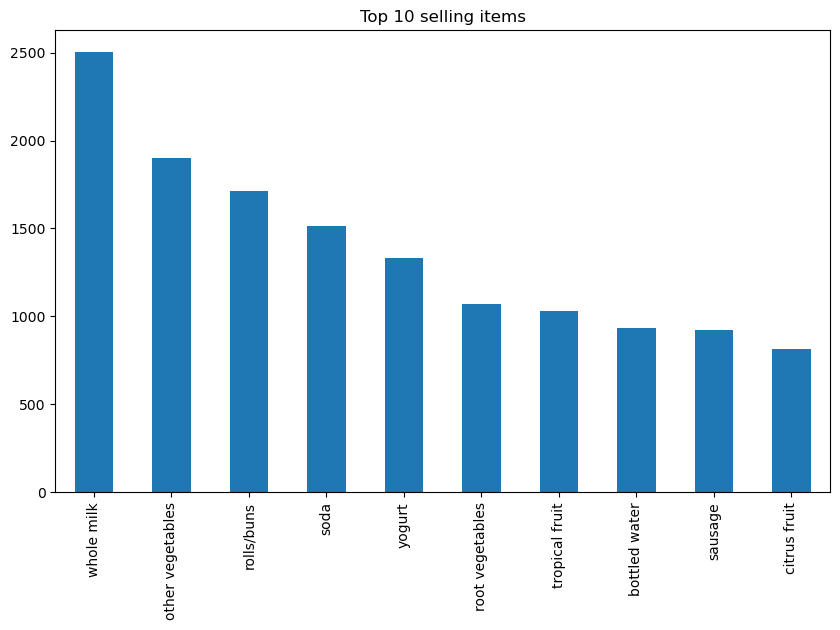

In [11]:
# Visualizations
plt.figure(figsize = (10,6))
df.itemDescription.value_counts().head(10).plot.bar()
plt.title('Top 10 selling items')

In [12]:
#item are the least selling?
df.itemDescription.value_counts().tail(10).sort_values()

kitchen utensil          1
preservation products    1
baby cosmetics           3
bags                     4
make up remover          5
toilet cleaner           5
frozen chicken           5
rubbing alcohol          5
salad dressing           6
whisky                   8
Name: itemDescription, dtype: int64

Text(0.5, 1.0, 'Top 10 least selling items')

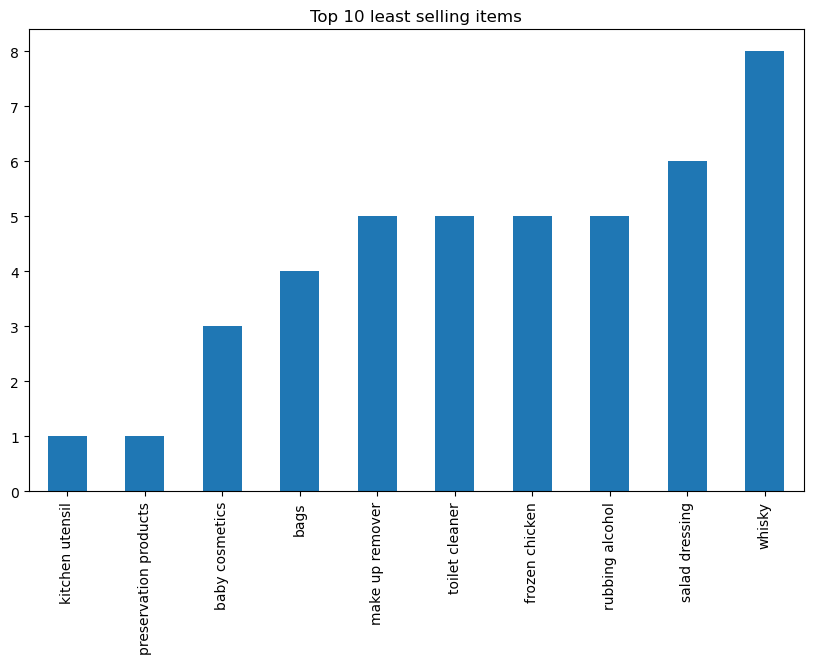

In [13]:
plt.figure(figsize = (10,6))
df.itemDescription.value_counts().tail(10).sort_values().plot.bar()
plt.title('Top 10 least selling items')

In [14]:
#Month-Year Sales
df_date=df.set_index(['Date']) ## Setting date as index for plotting purpose
df_date

,Member_number,itemDescription,year,month,day
Date,,,,,
2015-07-21,1808,tropical fruit,2015,7,21
2015-05-01,2552,whole milk,2015,5,1
2015-09-19,2300,pip fruit,2015,9,19
2015-12-12,1187,other vegetables,2015,12,12
2015-01-02,3037,whole milk,2015,1,2
...,...,...,...,...,...
2014-08-10,4471,sliced cheese,2014,8,10
2014-02-23,2022,candy,2014,2,23
2014-04-16,1097,cake bar,2014,4,16


[Text(0.5, 0, 'Date'), Text(0, 0.5, 'Number of Items Sold')]

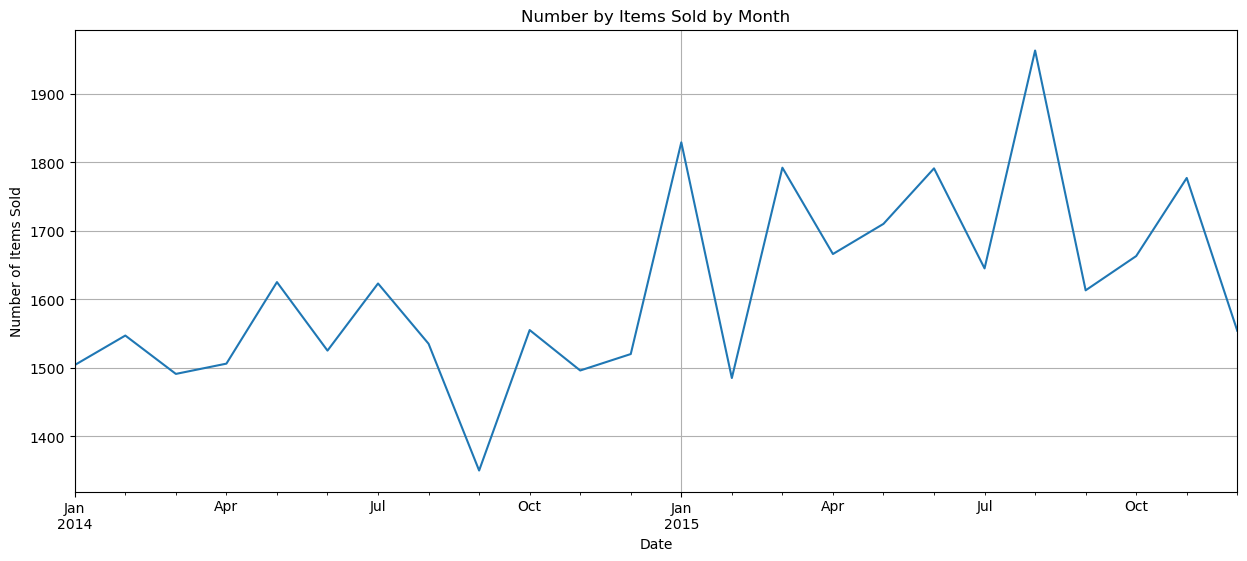

In [15]:
df_date.resample("M")['itemDescription'].count().plot(figsize = (15,6), 
                                                      grid = True, title = "Number by Items Sold by Month").set(xlabel = "Date", 
                                                                                                                ylabel = "Number of Items Sold")

In [16]:
df.groupby(['year'])['month'].value_counts().sort_index()

year  month
2014  1        1504
      2        1547
      3        1491
      4        1506
      5        1625
      6        1525
      7        1623
      8        1535
      9        1350
      10       1555
      11       1496
      12       1520
2015  1        1829
      2        1485
      3        1792
      4        1666
      5        1710
      6        1791
      7        1645
      8        1963
      9        1613
      10       1663
      11       1777
      12       1554
Name: month, dtype: int64

In [17]:
transactions = [a[1]['itemDescription'].tolist() for a in list(df.groupby(['Member_number','Date']))]
transactions[:10]

[['whole milk', 'pastry', 'salty snack'],
 ['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['frankfurter', 'soda', 'whipped/sour cream'],
 ['frankfurter', 'curd'],
 ['beef', 'white bread']]

In [18]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_) 
df

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
14959,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14960,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Apriori algorithm

The Apriori Algorithm widely uses and is well-known for Association Rule mining, making it a popular choice in Market Basket Analysis Python. AI and SETM algorithms consider it more accurate. It helps to find frequent itemsets in transactions and identifies association rules between these items. The limitation of the Apriori Algorithm is frequent itemset generation. It needs to scan the database many times, leading to increased time and reduced performance as a computationally costly step because of a large dataset. It uses the concepts of Confidence and Support.

The Apriori algorithm has three main components:

- Support
- Confidence
- Lift

You can think of these as metrics that evaluate the relevance and popularity of each item combination.

    Rule X -> Y

### Support
The first component of the Apriori algorithm is support. We use it to assess the overall popularity of a given product with the following formula:

        Support = Frequency(X,Y) / Total transactions(N)

A high support value indicates that the item is present in most purchases, therefore marketers should focus on it more.

### Confidence
Confidence tells us the likelihood of different purchase combinations. We calculate that using the following formula:

        Confidence = Frequency(X,Y) / Frequency(X)

Confidence indicates the number of times the if-then statements are found true.

### Lift
Lift can be used to compare confidence with expected confidence, or how many times an if-then statement is expected to be found true.

        Lift = Support / Support(X) * Support(Y)

In [19]:
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True) 
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x)) 
frequent_itemsets

,support,itemsets,length
0,0.004010,(Instant food products),1
1,0.021386,(UHT-milk),1
2,0.001470,(abrasive cleaner),1
3,0.001938,(artif. sweetener),1
4,0.008087,(baking powder),1
...,...,...,...
745,0.001136,"(whole milk, rolls/buns, sausage)",3
746,0.001002,"(soda, whole milk, rolls/buns)",3
747,0.001337,"(yogurt, whole milk, rolls/buns)",3
748,0.001069,"(soda, whole milk, sausage)",3


In [20]:
frequent_itemsets[ frequent_itemsets['itemsets'] == {'whole milk', 'rolls/buns'} ]

,support,itemsets,length
677,0.013968,"(whole milk, rolls/buns)",2


The output gives us the support value for **(rolls/buns, whole milk)**. The support value says that this specific item appears in **1.39%** of the transactions.

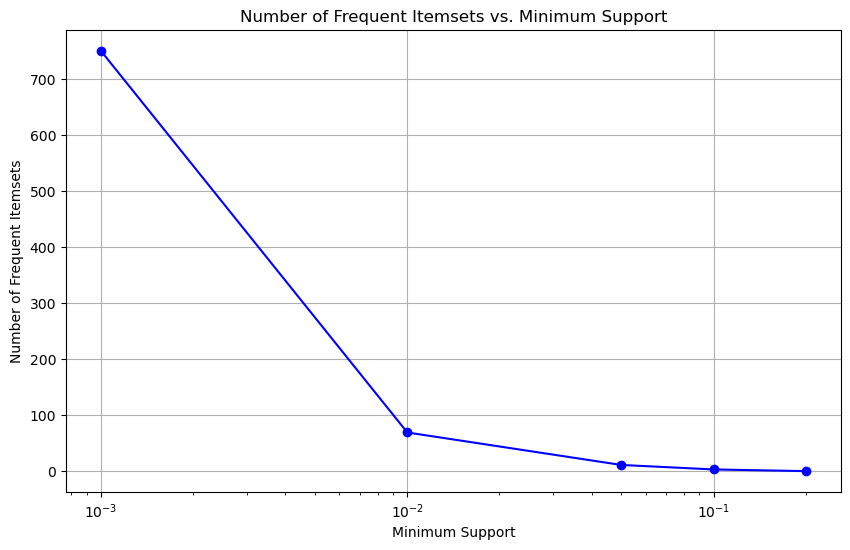

In [21]:
# Set the desired min_support values
support_values = [0.001, 0.01, 0.05, 0.1, 0.2]  # You can adjust the values here

# Create a list to store the number of itemsets
num_itemsets = []

for min_support in support_values:
    freq_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    num_itemsets.append(len(freq_itemsets))

# Create a DataFrame for plotting the graph
results_df = pd.DataFrame({
    'min_support': support_values,
    'num_itemsets': num_itemsets
})

# Plot a line graph
plt.figure(figsize=(10, 6))
plt.plot(results_df['min_support'], results_df['num_itemsets'], marker='o', linestyle='-', color='b')
plt.xscale('log')  # Use a logarithmic scale for min_support
plt.xlabel('Minimum Support')
plt.ylabel('Number of Frequent Itemsets')
plt.title('Number of Frequent Itemsets vs. Minimum Support')
plt.grid(True)
plt.show()

## FP-Growth Algorithm

- It is known as Frequent Pattern Growth Algorithm. FP growth algorithm is a concept of representing the data in the form of an FP tree or Frequent Pattern. Hence FP Growth is a method of Mining Frequent Itemsets. This algorithm is an advancement to the Apriori Algorithm. There is no need for candidate generation to generate a frequent pattern. This frequent pattern tree structure maintains the association between the itemsets.

- A Frequent Pattern Tree is a tree structure that is made with the earlier itemsets of the data. The main purpose of the FP tree is to mine the most frequent patterns. Every node of the FP tree represents an item of that itemset. The root node represents the null value, whereas the lower nodes represent the itemsets of the data. While creating the tree, it maintains the association of these nodes with the lower nodes, namely, between itemsets.

In [22]:
fpgrowth(df, min_support=0.01, use_colnames=True)

,support,itemsets
0,0.157923,(whole milk)
1,0.051728,(pastry)
2,0.018780,(salty snack)
3,0.085879,(yogurt)
4,0.060349,(sausage)
...,...,...
64,0.011161,"(yogurt, whole milk)"
65,0.011629,"(soda, whole milk)"
66,0.013968,"(whole milk, rolls/buns)"
67,0.010559,"(other vegetables, rolls/buns)"


## Comparison between Apriori and Fpgrowth Algorithm

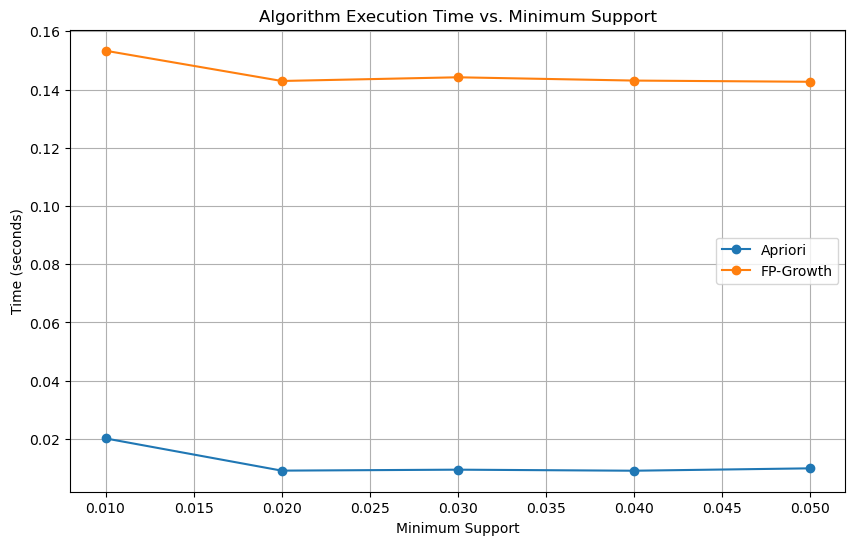

In [23]:
# Create a list of min_support values to test
min_support_values = [0.01, 0.02, 0.03, 0.04, 0.05]
apriori_times = []
fpgrowth_times = []

# Prepare the data
te = TransactionEncoder()
te_ary = te.fit(df).transform(df)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Measure the execution time for each min_support value
for min_support in min_support_values:
    apriori_time = timeit.timeit(lambda: apriori(df, min_support=min_support), number=10)
    fpgrowth_time = timeit.timeit(lambda: fpgrowth(df, min_support=min_support), number=10)
    
    apriori_times.append(apriori_time)
    fpgrowth_times.append(fpgrowth_time)

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(min_support_values, apriori_times, marker='o', label='Apriori')
plt.plot(min_support_values, fpgrowth_times, marker='o', label='FP-Growth')
plt.xlabel('Minimum Support')
plt.ylabel('Time (seconds)')
plt.title('Algorithm Execution Time vs. Minimum Support')
plt.legend()
plt.grid(True)
plt.show()

The comparison between the Apriori and FP-Growth algorithms shows that Apriori performs faster when the dataset is small or not complex. Therefore, this dataset is suitable for using the Apriori algorithm.

## Deriving Association Rules

### Association Rule
- Association rule mining, at a basic level, involves the use of machine learning models to analyze data for patterns, or co-occurrences, in a database. It identifies frequent if-then associations, which themselves are the association rules. An association rule has two parts: an antecedent (if) and a consequent (then). An antecedent is an item found within the data. A consequent is an item found in combination with the antecedent.

- Association rules are calculated from itemsets, which are made up of two or more items. If rules are built from analyzing all the possible itemsets, there could be so many rules that the rules hold little meaning. With that, association rules are typically created from rules well-represented in data.

In [24]:
rules = association_rules(frequent_itemsets, metric="lift")
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(UHT-milk),(bottled water),0.021386,0.060683,0.001069,0.050000,0.823954,-0.000228,0.988755,-0.179204
1,(bottled water),(UHT-milk),0.060683,0.021386,0.001069,0.017621,0.823954,-0.000228,0.996168,-0.185312
2,(UHT-milk),(other vegetables),0.021386,0.122101,0.002139,0.100000,0.818993,-0.000473,0.975443,-0.184234
3,(other vegetables),(UHT-milk),0.122101,0.021386,0.002139,0.017515,0.818993,-0.000473,0.996060,-0.201119
4,(UHT-milk),(sausage),0.021386,0.060349,0.001136,0.053125,0.880298,-0.000154,0.992371,-0.121998


Here, the “antecedents” and “consequents” columns show items that are frequently purchased together.

In this example, the first row of the dataset tells us that if a person were to buy bottled water, then they are also likely to purchase UHT-milk.

To get the most frequent item combinations in the entire dataset, let’s sort the dataset by support, confidence, and lift:

In [25]:
rules.sort_values(["support", "confidence","lift"],axis = 0, ascending = False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
623,(rolls/buns),(whole milk),0.110005,0.157923,0.013968,0.126974,0.804028,-0.003404,0.964550,-0.214986
622,(whole milk),(rolls/buns),0.157923,0.110005,0.013968,0.088447,0.804028,-0.003404,0.976350,-0.224474
694,(yogurt),(whole milk),0.085879,0.157923,0.011161,0.129961,0.822940,-0.002401,0.967861,-0.190525
695,(whole milk),(yogurt),0.157923,0.085879,0.011161,0.070673,0.822940,-0.002401,0.983638,-0.203508
550,(soda),(other vegetables),0.097106,0.122101,0.009691,0.099794,0.817302,-0.002166,0.975219,-0.198448
551,(other vegetables),(soda),0.122101,0.097106,0.009691,0.079365,0.817302,-0.002166,0.980729,-0.202951
649,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811,-0.063965
648,(whole milk),(sausage),0.157923,0.060349,0.008955,0.056708,0.939663,-0.000575,0.996140,-0.070851
624,(yogurt),(rolls/buns),0.085879,0.110005,0.007819,0.091051,0.827697,-0.001628,0.979147,-0.185487
625,(rolls/buns),(yogurt),0.110005,0.085879,0.007819,0.071081,0.827697,-0.001628,0.984071,-0.189562


## Conclusion
The resulting table shows that the five most popular product combinations that are frequently bought together are:

- (Rolls/buns) and milk
- Yogurt and milk
- Sausages and milk
- Soda and vegetables
- Yogurt and (Rolls/buns)

One reason for this could be that the grocery store ran a promotion on these items together or displayed them within the same line of sight to improve sales.